# Book Clustering Statistics

This notebook provides statistics on the results of our book clustering.

## Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Load Data

Let's start by getting our clusters and their statistics:

In [2]:
clusters = pd.read_parquet('book-links/cluster-stats.parquet')
clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32507472 entries, 0 to 32507471
Data columns (total 8 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   cluster        int32 
 1   n_nodes        uint32
 2   n_isbns        uint32
 3   n_loc_recs     uint32
 4   n_ol_editions  uint32
 5   n_ol_works     uint32
 6   n_gr_books     uint32
 7   n_gr_works     uint32
dtypes: int32(1), uint32(7)
memory usage: 992.0 MB


In [3]:
clusters.set_index('cluster', inplace=True)

Describe the count columns for basic descriptive stats:

In [4]:
clusters.describe()

,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
count,3.250747e+07,3.250747e+07,3.250747e+07,3.250747e+07,3.250747e+07,3.250747e+07,3.250747e+07
mean,3.285370e+00,1.030693e+00,2.974880e-01,1.068522e+00,7.692291e-01,7.261884e-02,4.681884e-02
std,9.915841e+00,5.042100e+00,5.476829e-01,3.749919e+00,7.010148e-01,1.097031e+00,2.205859e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,4.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,2.902000e+04,1.437800e+04,6.730000e+02,9.939000e+03,2.368000e+03,3.390000e+03,1.320000e+02


75% of clusters only contain 2 ISBNs (probably -10 and -13) and one book. OpenLibrary also contributes to the largest number of clusters.

## Clusters per Source

How many clusters are connected to each source?

In [5]:
src_counts = pd.Series(dict(
    (c, np.sum(clusters[c] > 0)) for c in clusters.columns
))
src_counts

n_nodes          32507472
n_isbns          17673075
n_loc_recs        9281527
n_ol_editions    25814126
n_ol_works       23754493
n_gr_books        1506186
n_gr_works        1505662
dtype: int64

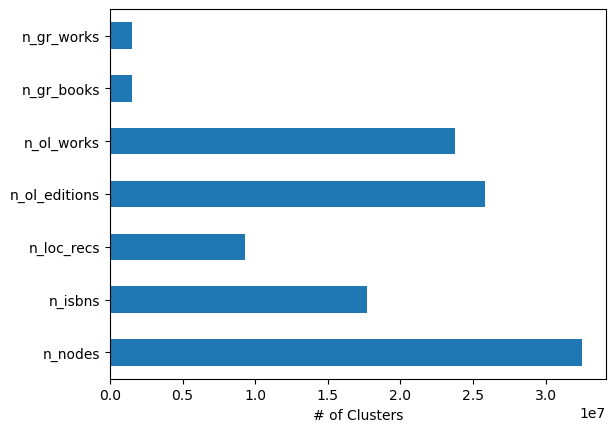

In [6]:
src_counts.plot.barh()
plt.xlabel('# of Clusters')
plt.show()

## Distributions

Let's look at the distributions of cluster sizes.

In [7]:
size_dist = pd.concat(dict(
    (c, clusters[c].value_counts()) for c in clusters.columns if c != 'n_nodes'
), names=['RecType'])
size_dist.index.set_names(['RecType', 'RecCount'], inplace=True)
size_dist = size_dist.reset_index(name='Clusters')
size_dist.head()

,RecType,RecCount,Clusters
0,n_isbns,0,14834397
1,n_isbns,1,8270663
2,n_isbns,2,7435667
3,n_isbns,4,737602
4,n_isbns,3,617823


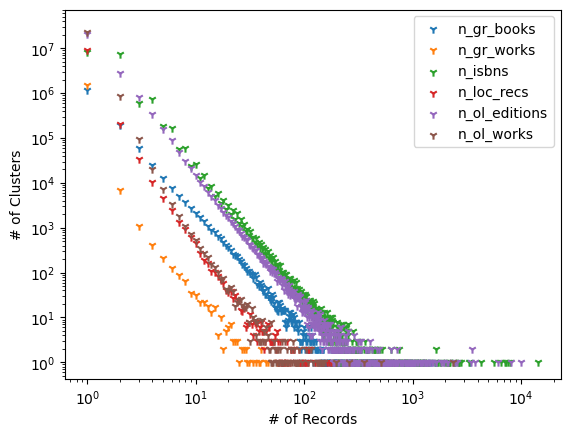

In [8]:
for rt, data in size_dist.groupby('RecType'):
    plt.scatter(data['RecCount'], data['Clusters'], marker='1', label=rt)
plt.legend()
plt.xlabel('# of Records')
plt.xscale('log')
plt.ylabel('# of Clusters')
plt.yscale('log')
plt.show()

Looks mostly fine - we expect a lot of power laws - but the number of clusters with merged GoodReads works is concerning.

## GoodReads Work Merging

Why are GoodReads works merging? Let's look at those.

In [9]:
gr_big = clusters[clusters['n_gr_works'] > 1].sort_values('n_gr_works', ascending=False)
gr_big.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9258 entries, 100026918 to 109397422
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   n_nodes        9258 non-null   uint32
 1   n_isbns        9258 non-null   uint32
 2   n_loc_recs     9258 non-null   uint32
 3   n_ol_editions  9258 non-null   uint32
 4   n_ol_works     9258 non-null   uint32
 5   n_gr_books     9258 non-null   uint32
 6   n_gr_works     9258 non-null   uint32
dtypes: uint32(7)
memory usage: 325.5 KB


We have a lot of these clusters. What fraction of the GoodReads-affected clusters is this?

In [10]:
len(gr_big) / clusters['n_gr_books'].count()

0.00028479606165622475

Less than 1%. Not bad, but let's look.

In [11]:
gr_big.head()

,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
cluster,,,,,,,
100026918,29020,14378,673,9939,508,3390,132
100073294,17883,7331,496,8126,360,1481,89
100227025,6811,3314,192,2555,258,422,70
100122502,454,165,4,93,76,60,56
104486307,315,141,1,51,18,53,51


## Large Cluster Debugging

We have some pretty big clusters:

In [12]:
big = clusters.nlargest(5, 'n_nodes')
big

,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
cluster,,,,,,,
100026918,29020,14378,673,9939,508,3390,132
100073294,17883,7331,496,8126,360,1481,89
100044980,15635,7836,186,6168,89,1333,23
102066477,11281,7520,0,3760,1,0,0
100063034,11098,5647,178,3484,145,1599,45


What is up with this? We should figure out what went wrong, if we can.  What are its ISBNs?

In [13]:
isbns = pd.read_parquet('book-links/all-isbns.parquet').set_index('isbn_id')
isbns.head()

,isbn,LOC,GR,AZ14,BX,OL,AZ18
isbn_id,,,,,,,
1,0836932722,2,0,0,0,3,0
2,0965406334,1,0,0,0,1,0
3,0780363175,1,0,0,0,2,0
4,0780363590,1,0,0,0,2,0
5,0780363604,1,0,0,0,2,0


In [14]:
links = pd.read_parquet('book-links/isbn-clusters.parquet', columns=['isbn_id', 'cluster'])
links.head()

,isbn_id,cluster
0,33505211,933505211
1,33505210,933505210
2,33505209,933505209
3,33505208,933505208
4,33505207,933505207


In [15]:
big_id = big.index[0]
bl = links[links['cluster'] == big_id].drop(columns=['cluster'])
bl = bl.join(isbns, on='isbn_id')
bl.sort_values('isbn')

,isbn_id,isbn,LOC,GR,AZ14,BX,OL,AZ18
33471641,20024983,0001004735,0,0,0,0,1,0
33479140,16149125,0001848259,0,0,0,0,1,0
33477592,16009556,0001849123,0,0,0,0,1,0
33480336,19266442,0001956795,0,0,0,0,1,0
33468668,12648234,0003302245,0,0,0,0,1,3900
...,...,...,...,...,...,...,...,...
33478134,9719710,B073GF59RD,0,1,0,0,0,0
33478617,9842727,B073GGNYFL,0,1,0,0,0,0
33477529,9870129,B073MZ23QX,0,1,0,0,0,0
33470867,9736422,B074P9CM5T,0,1,0,0,0,0


What are the things with the highest record count (besides ratings)?

In [16]:
bl['btot'] = bl.iloc[:, 2:-2].sum(axis=1)
bl.nlargest(20, 'btot')

,isbn_id,isbn,LOC,GR,AZ14,BX,OL,AZ18,btot
33468367,3578943,014143984X,1,1,1614,9,3,0,1625
33469985,7916032,0141439769,0,1,1353,2,1,0,1356
33466510,7364014,0140621199,0,1,1185,18,2,0,1204
33475432,7417615,0140390839,0,1,993,11,1,0,1005
33478280,8026559,006440188X,0,1,549,50,2,0,600
33473960,8115792,0141321008,0,1,509,0,1,0,510
33477391,9583488,B0084AVKZ2,0,1,377,0,0,0,378
33477084,7641152,0199538794,0,1,363,0,0,0,364
33472589,9733443,B002RKRMSY,0,1,329,0,0,0,330
33479498,9806844,B002RKSZJO,0,1,328,0,0,0,329
